# Method 1: Convolutional Neural Network

For the first method, we decided to use a CNN which benefits from images as input. We can apply filters and kernel functions to reduce the dimensionality of our images.

## 1. Getting Started

First, we import the libraries we are going to use to train our Convolutional Neural Network. We will also define the environments relative paths and some utility/auxiliary functions.

### 1.1 Imports

In [1]:
import os
import sys
import csv
import random

import cv2
import numpy as np
import torch.nn as nn

### 1.2 Environment Configuration

In [2]:
# Setting the path of the training dataset (that was already provided to you)

running_local = True if os.getenv('JUPYTERHUB_USER') is None else False
DATASET_PATH = "../data/sign_lang_train"

# Set the location of the dataset
if running_local:
    # If running on your local machine, the sign_lang_train folder's path should be specified here
    local_path = "../data/sign_lang_train"
    if os.path.exists(local_path):
        DATASET_PATH = local_path
else:
    # If running on the Jupyter hub, this data folder is already available
    # You DO NOT need to upload the data!
    DATASET_PATH = "/data/mlproject22/sign_lang_train"

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

### 1.3 Auxiliary Functions

In [3]:
# Auxiliary function
def read_csv(csv_file):
    with open(csv_file, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
    return data

### 1.4 Define the Dataset Class (Sign-Languages)
This class will hold the dataset we were given (Sign-Languages)

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

from string import ascii_lowercase

class SignLangDataset(Dataset):
    """Sign language dataset"""

    def __init__(self, csv_file, root_dir, class_index_map=None, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = read_csv(os.path.join(root_dir,csv_file))
        self.root_dir = root_dir
        self.class_index_map = class_index_map
        self.transform = transform
        # List of class names in order
        self.class_names = list(map(str, list(range(10)))) + list(ascii_lowercase)

    def __len__(self):
        """
        Calculates the length of the dataset-
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns one sample (dict consisting of an image and its label)
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Read the image and labels
        image_path = os.path.join(self.root_dir, self.data[idx][1])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # The Shape of the image should be H, W, C where C=1
        image = np.expand_dims(image, 0)
        # The label is the index of the class name in the list ['0','1',...,'9','a','b',...'z']
        # because we should have integer labels in the range 0-35 (for 36 classes)
        label = self.class_names.index(self.data[idx][0])

        sample = {'image': image, 'label': label}
        if self.transform:
            sample = self.transform(sample)
        return sample

#### 1.4.1 Define a Class for a combined Dataset to hold our augmented data

In [5]:
class CombinedDataset(Dataset):
    def __init__(self, original_dataset, augmentation):
        self.original_dataset = original_dataset
        self.augmented_data = augmentation
        self.class_names = original_dataset.class_names
    def __len__(self):
        return len(self.original_dataset) + len(self.augmented_data)

    def __getitem__(self, idx):
        if idx < len(self.original_dataset):
            return self.original_dataset[idx]
        else:
            aug_idx = idx - len(self.original_dataset)
            return self.augmented_data[aug_idx]

### 1.5 Import the Network
Now we import the CNN class from /src and load the weights from previous sessions, or initialize it if it does not exist yet.

In [6]:
from src.conv_nn import ConvNN

#ConvNN?
#ConvNN??
#help(ConvNN)

cnn = ConvNN().float()
cnn.train()

filename = "../models/cnn_weights.pt"

if not os.path.exists(filename):
    cnn.init_weights()
    torch.save(cnn.state_dict(), filename)
    print(f"Initialized weights saved to '{filename}'")
else:
    print(f"File '{filename}' already exists, skipping initialization.")

cnn.load_state_dict(torch.load("../models/cnn_weights.pt"))

print("ConvNN imported successfully!")

Initialized weights saved to '../models/cnn_weights.pt'
ConvNN imported successfully!


### 1.6 Instantiate the Dataset

In [7]:
from torch.utils.data import random_split, DataLoader

dataset = SignLangDataset(csv_file='labels.csv', root_dir=DATASET_PATH)

### 1.7 Visualize the Data

We need to visualize the data to check for class imbalance. This is crucial for the training, because our model cannot learn well from underrepresented classes and might not be able to make correct predictions for underrepresented classes.

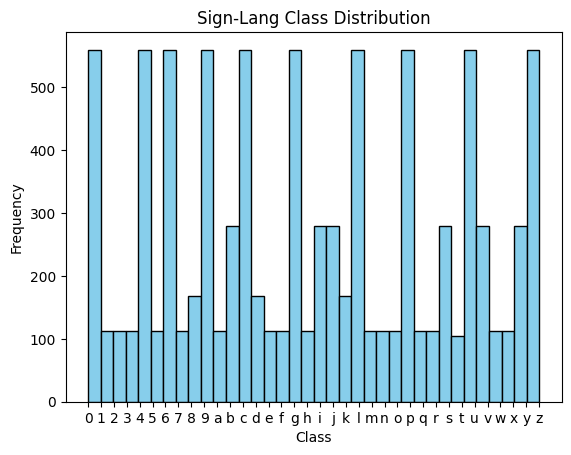

In [8]:
import matplotlib.pyplot as plt
from collections import defaultdict

def show_class_balancing(dataset):

    labels = [data['label'] for data in dataset]

    plt.hist(labels, bins=36, color='skyblue', edgecolor='black')

    plt.title('Sign-Lang Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(range(len(dataset.class_names)), dataset.class_names)

    plt.show()

show_class_balancing(dataset)

As we can clearly see now there is a class imbalance.

In [9]:
clustered_data = defaultdict(list)

max_bucket_size = 0

for data in dataset:
    clustered_data[data['label']].append(data)

for bucket in clustered_data.values():
    len_bucket = len(bucket)
    if len_bucket > max_bucket_size:
        max_bucket_size = len_bucket

for label, bucket in clustered_data.items():
    if len(bucket) < max_bucket_size - max_bucket_size * 0.1:
        print(f"To few Images of label: {label}; counted: {len(bucket)}")

To few Images of label: 7; counted: 112
To few Images of label: 18; counted: 280
To few Images of label: 31; counted: 280
To few Images of label: 17; counted: 112
To few Images of label: 13; counted: 168
To few Images of label: 2; counted: 112
To few Images of label: 29; counted: 104
To few Images of label: 33; counted: 112
To few Images of label: 23; counted: 112
To few Images of label: 14; counted: 112
To few Images of label: 26; counted: 112
To few Images of label: 5; counted: 112
To few Images of label: 24; counted: 112
To few Images of label: 28; counted: 280
To few Images of label: 8; counted: 168
To few Images of label: 20; counted: 168
To few Images of label: 22; counted: 112
To few Images of label: 19; counted: 280
To few Images of label: 11; counted: 280
To few Images of label: 34; counted: 280
To few Images of label: 27; counted: 112
To few Images of label: 15; counted: 112
To few Images of label: 32; counted: 112
To few Images of label: 10; counted: 112
To few Images of lab

### 1.8 Augment the Data
In this step, we will use augmentation to synthesize more data. In particular, we will do so by filling up the gaps between underrepresented classes and highly represented classes. So we add new images of underrepresented classes by taking already existing images from the dataset and modifying them slightly. This is useful because the model will learn shapes of certain classes more flexible.

In [10]:
from torchvision import transforms
from torchvision.transforms import v2
from PIL import Image

augmented_data = []

augment = transforms.Compose([
    v2.RandomPerspective(distortion_scale=0.15),
    v2.RandomRotation(degrees=27),
    v2.RandomApply([v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))]),
    transforms.ToTensor()
])

max_show = 8

for label, bucket in clustered_data.items():
    len_bucket = len(bucket)

    if len_bucket < max_bucket_size - max_bucket_size * 0.1:
        needed = int((max_bucket_size - len_bucket) * random.uniform(0.9, 1.1))

        for i in range(needed):
            img_np = random.choice(bucket)['image']
            img_2d = np.squeeze(img_np, axis=0)
            img_pil = Image.fromarray(img_2d.astype(np.uint8), mode='L')

            augmented_img = augment(img_pil)
            augmented_np = augmented_img.numpy()

            augmented_data.append({'image': augmented_np, 'label': label})

print(f"Augmented {len(augmented_data)} images.")

Augmented 10415 images.


We introduced a little bit of randomness in how many pictures are created, because we don't want the exact same number of images for each class. Also augmentatin is applied randomly. The next cell shows a few examples for each augmented class.

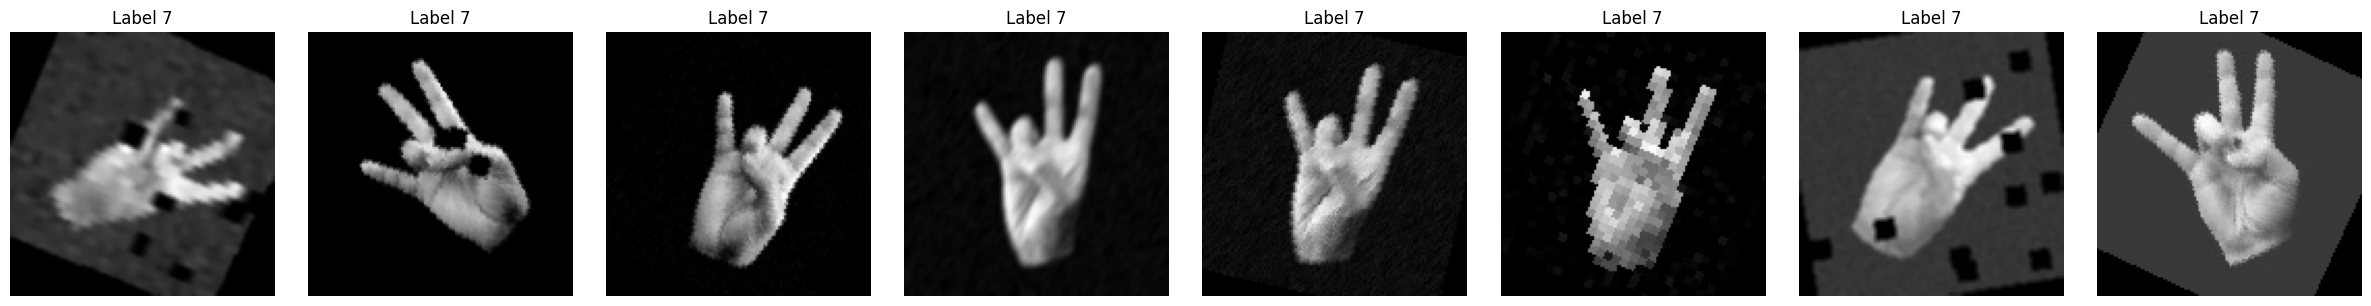

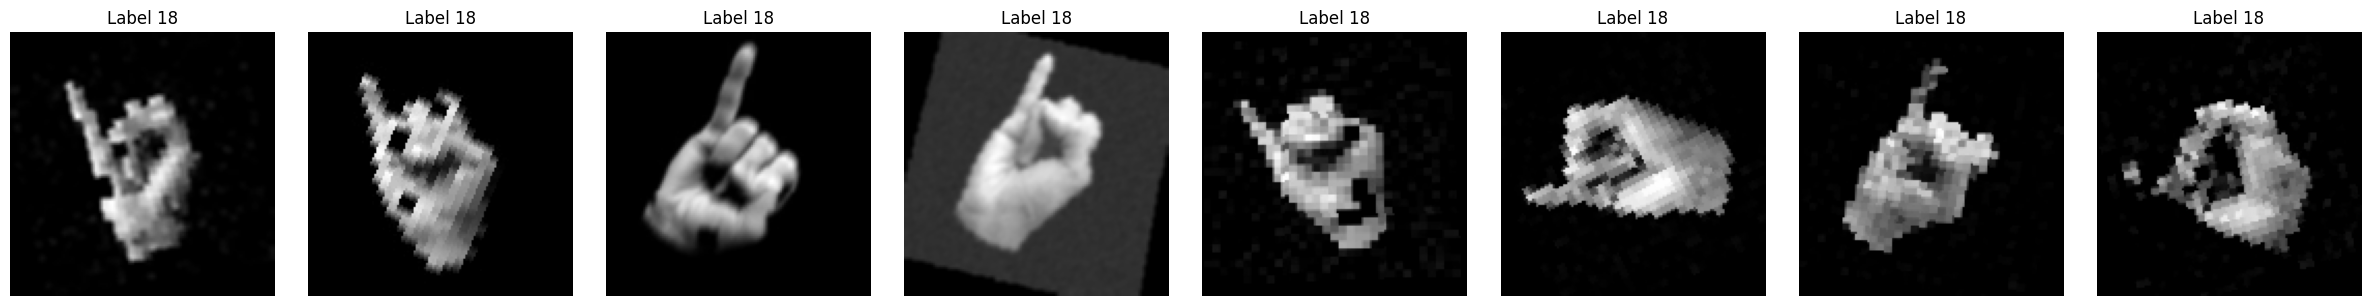

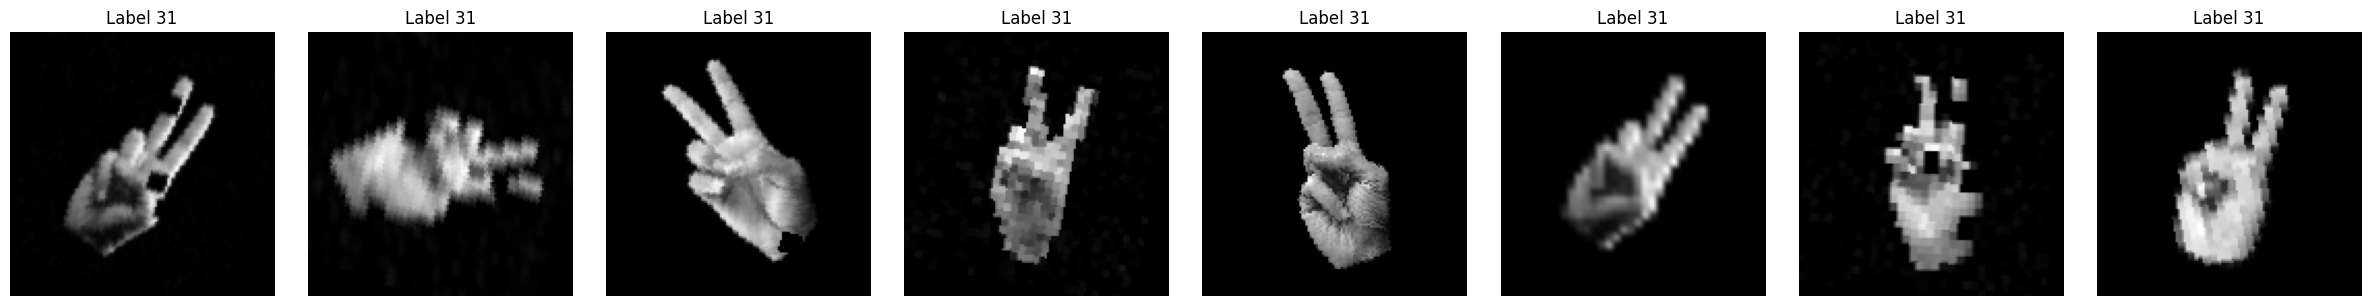

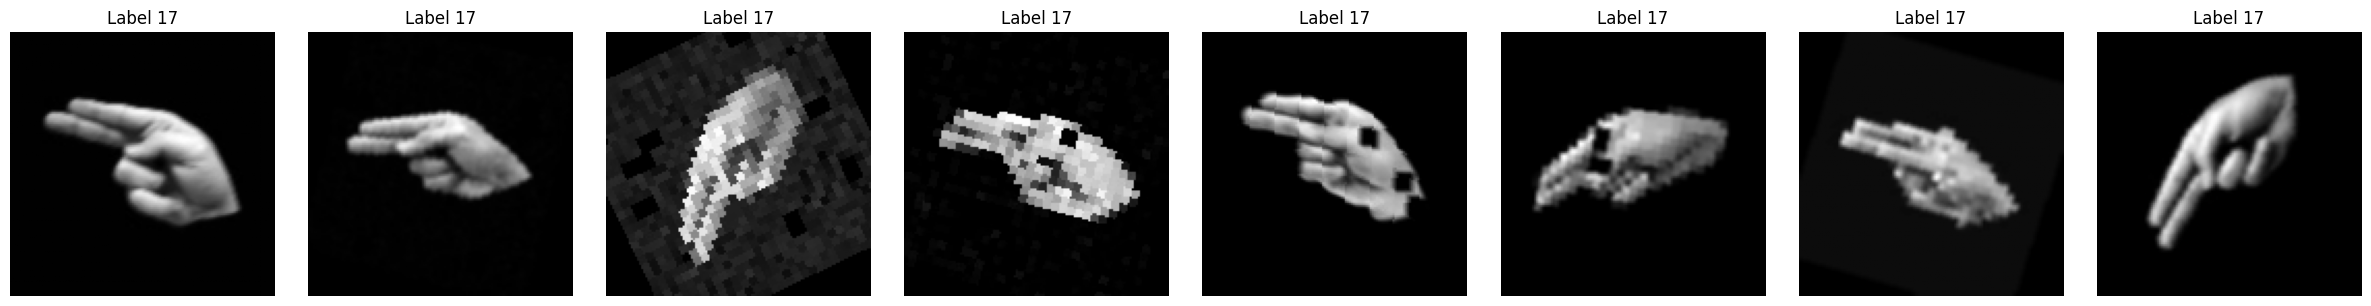

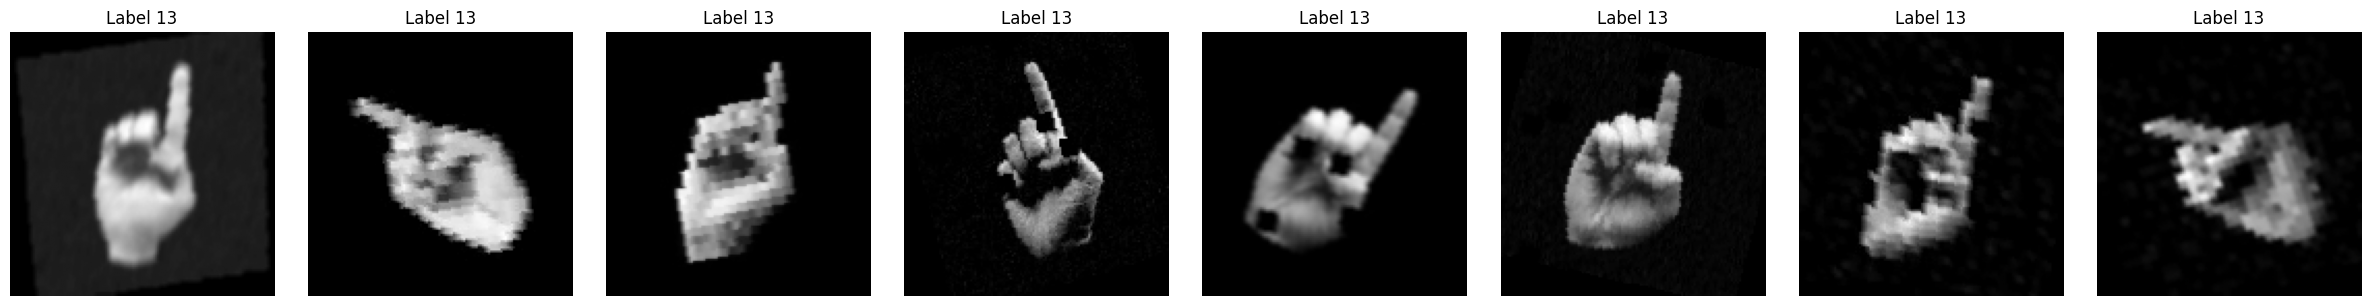

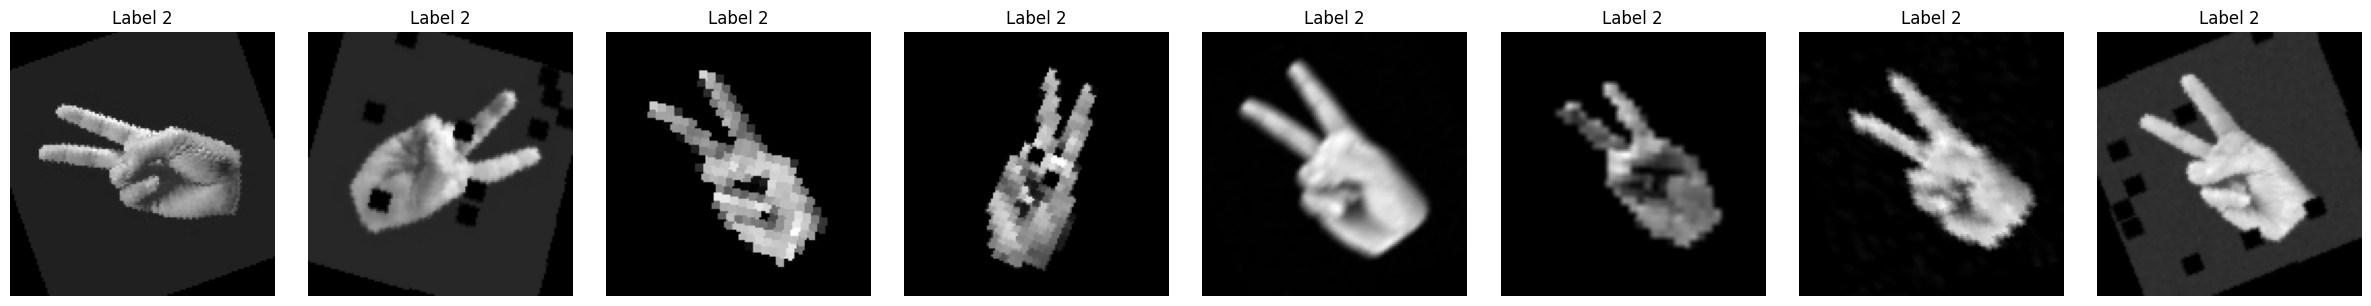

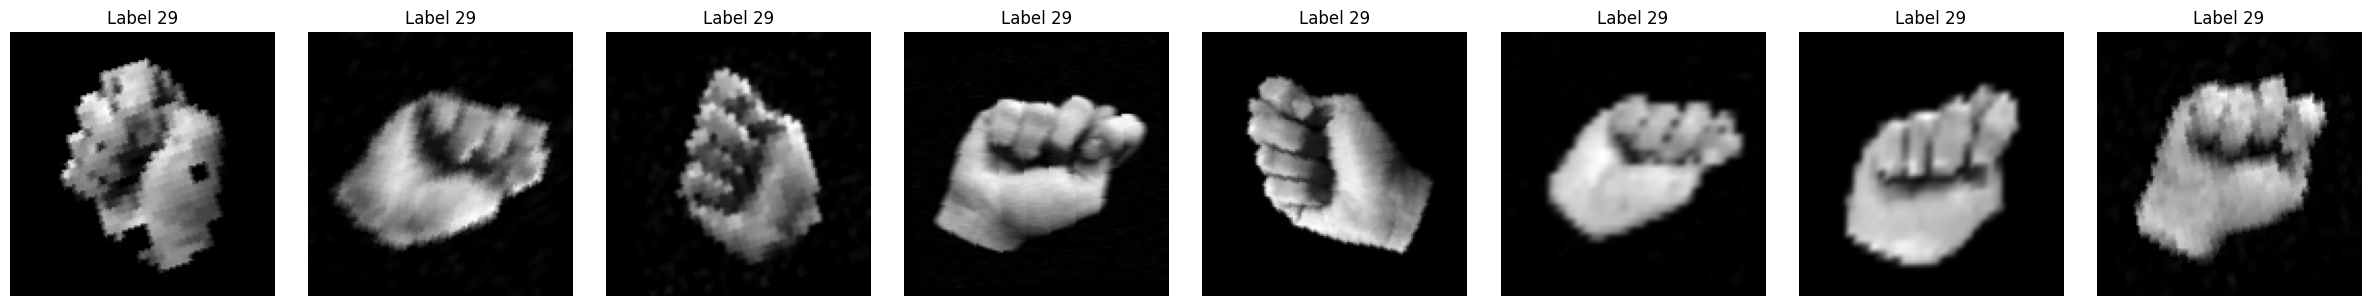

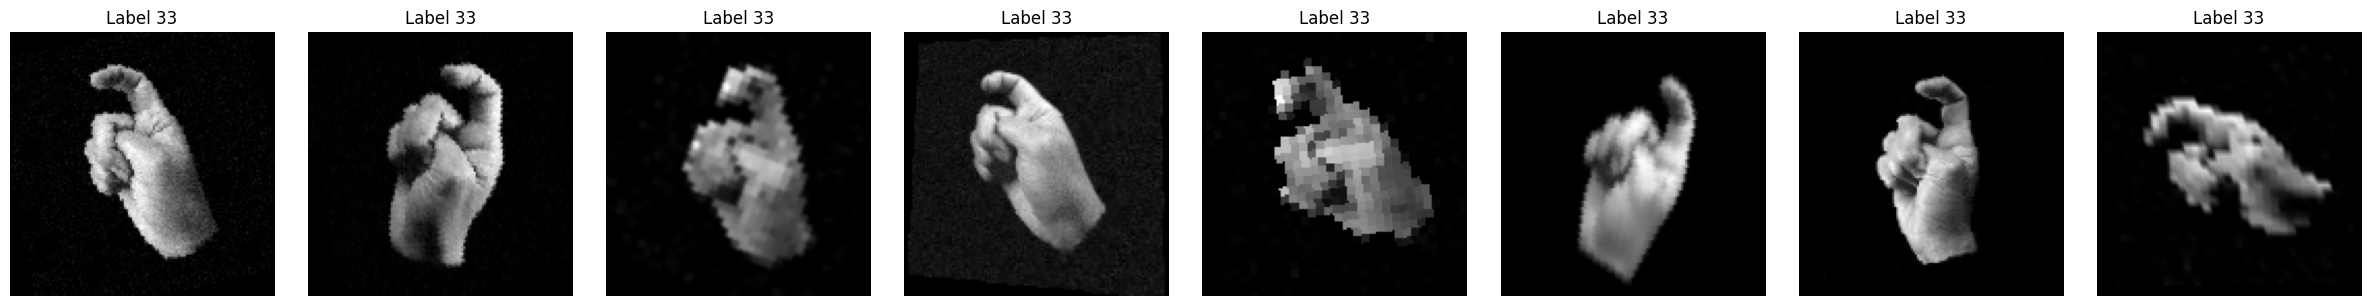

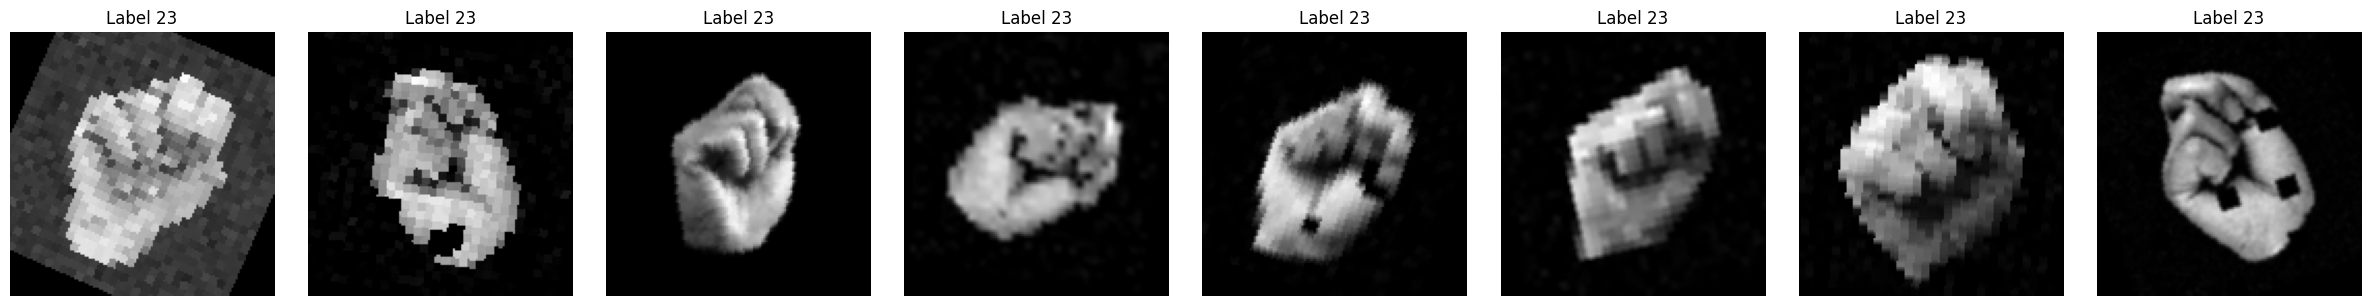

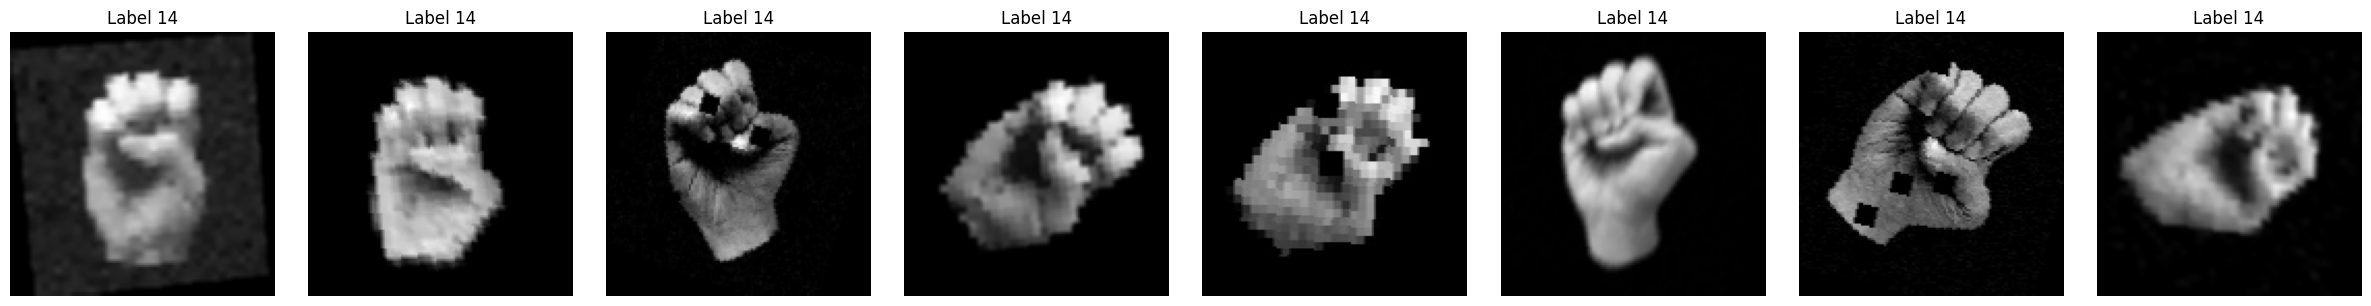

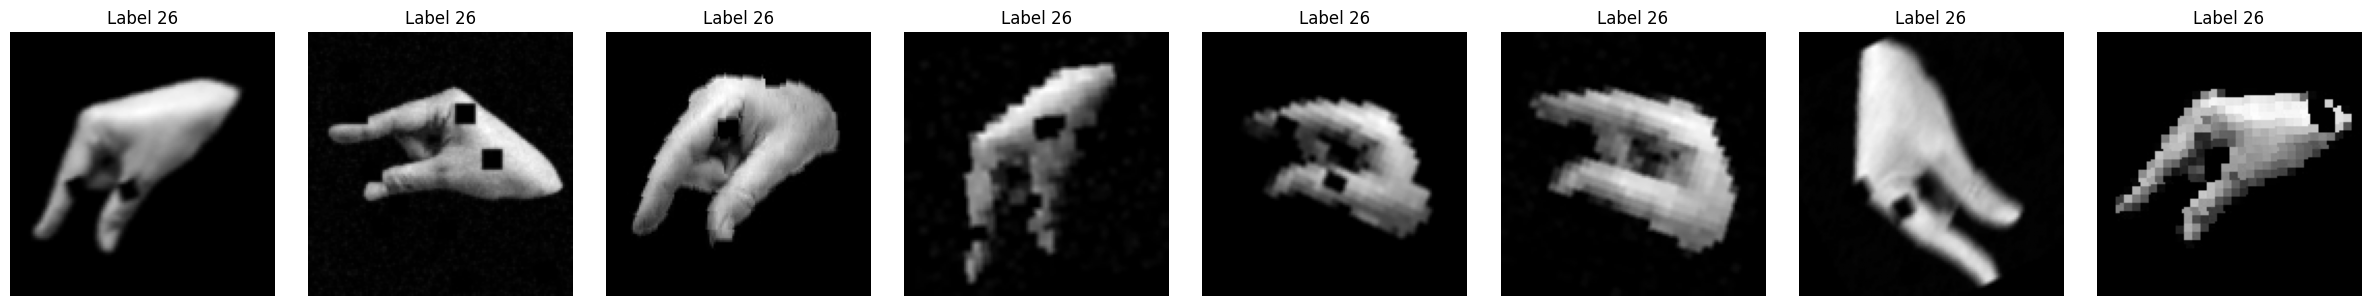

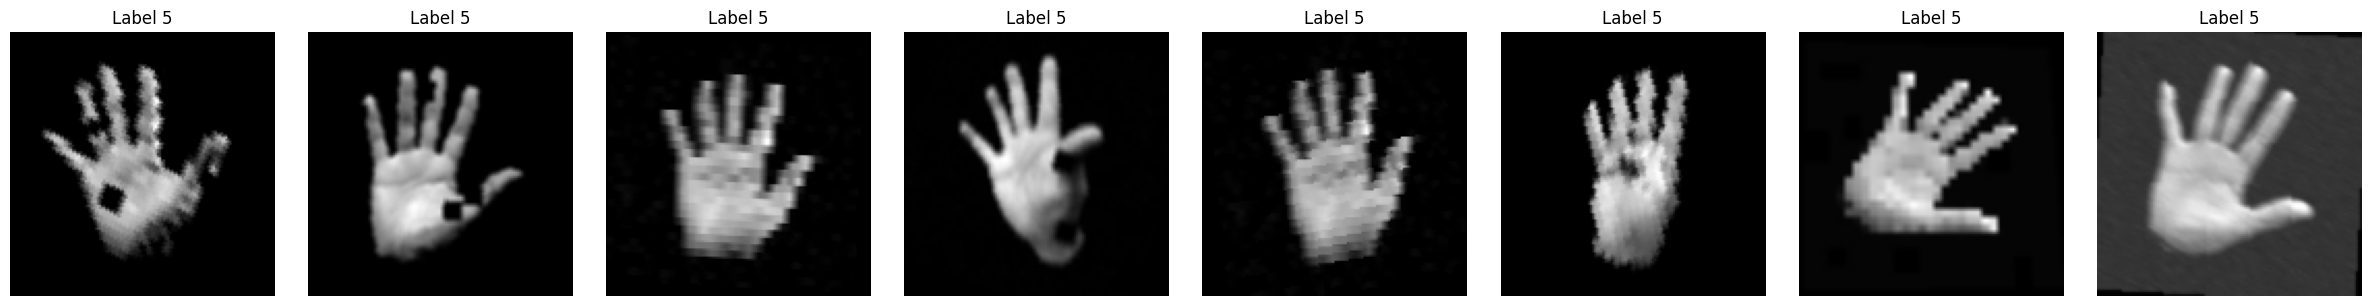

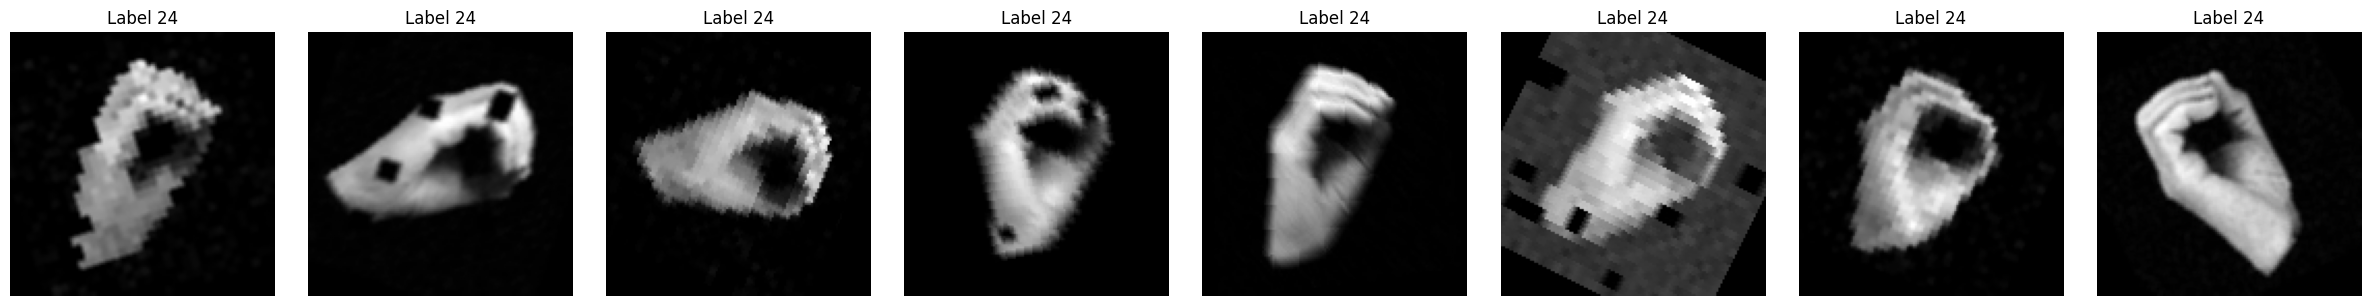

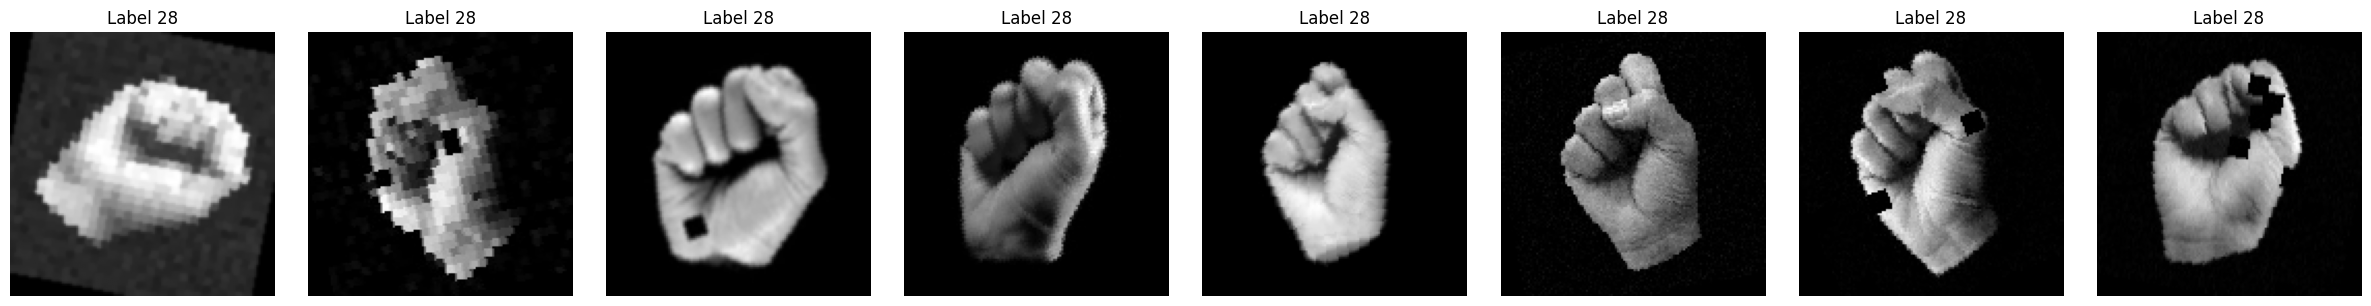

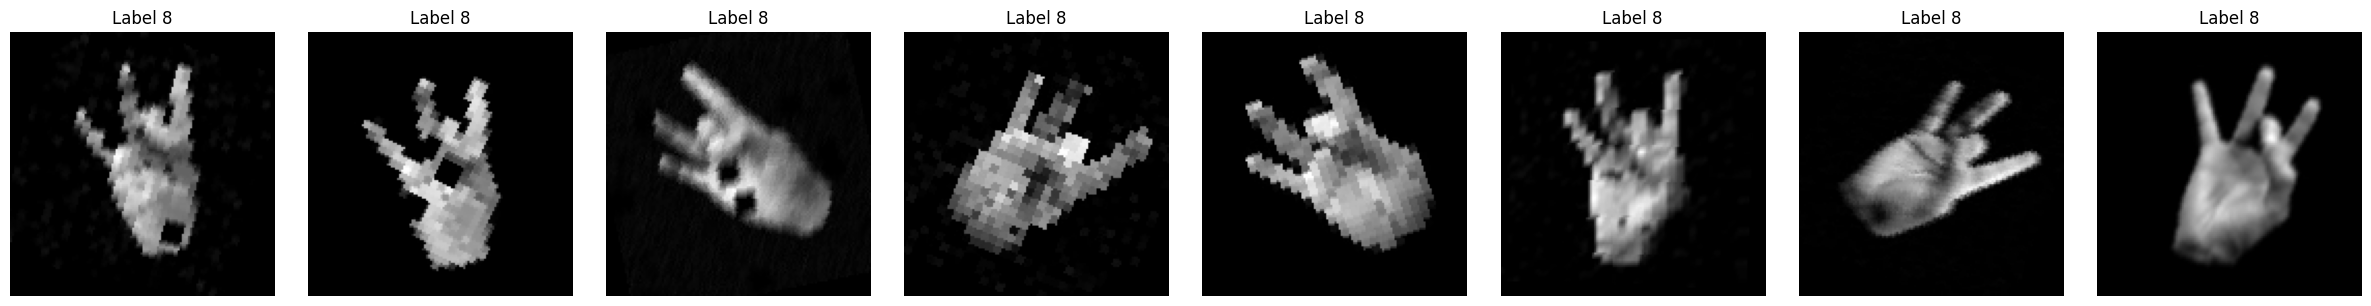

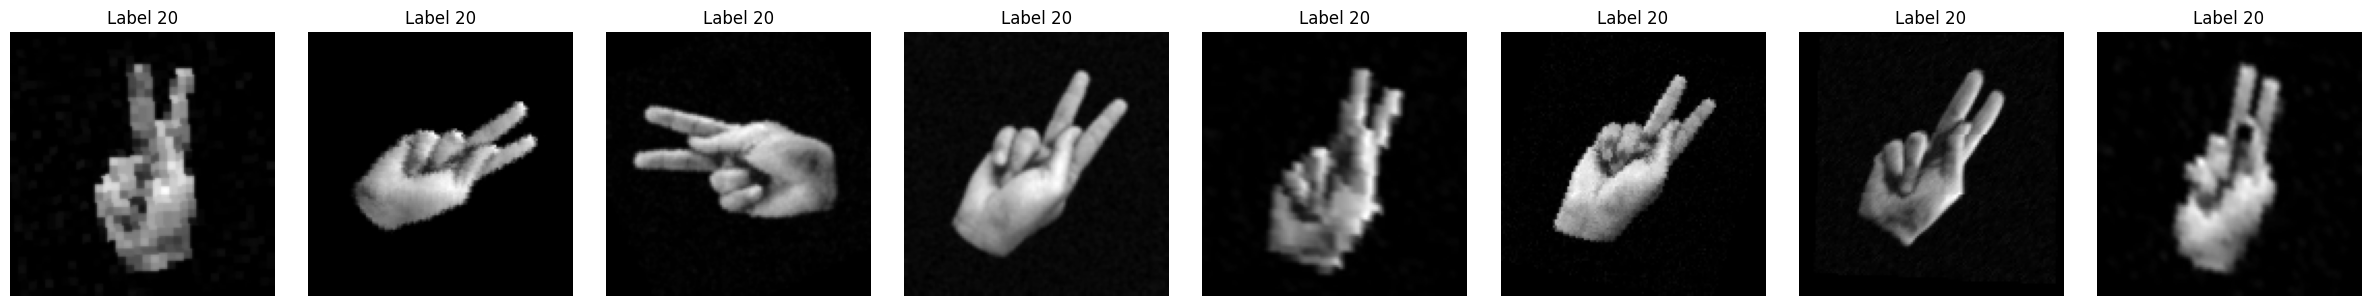

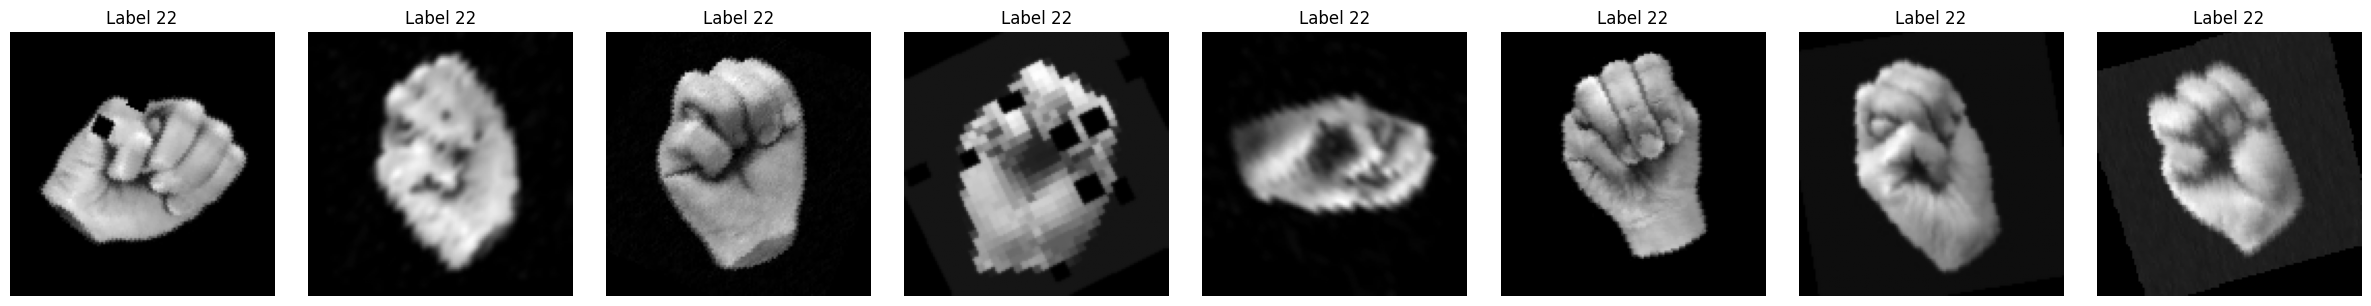

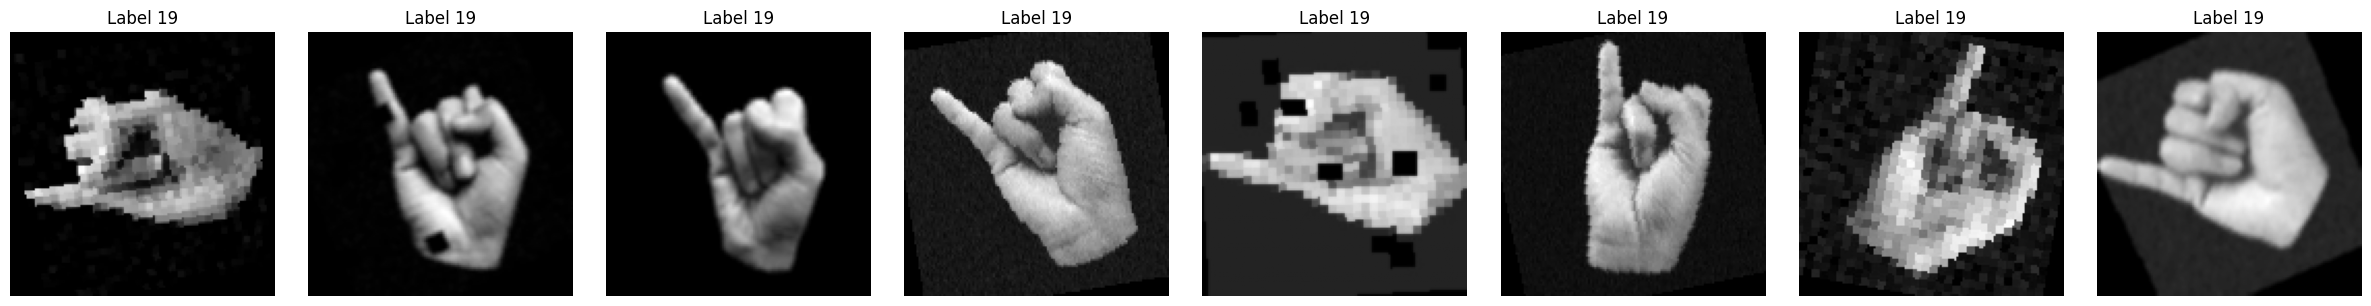

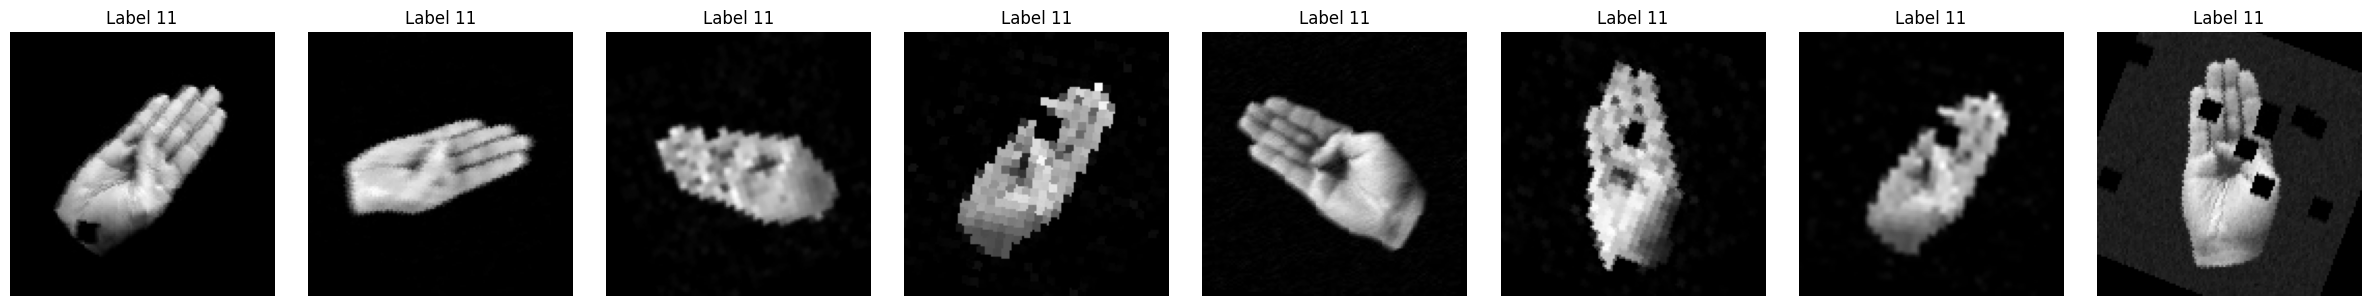

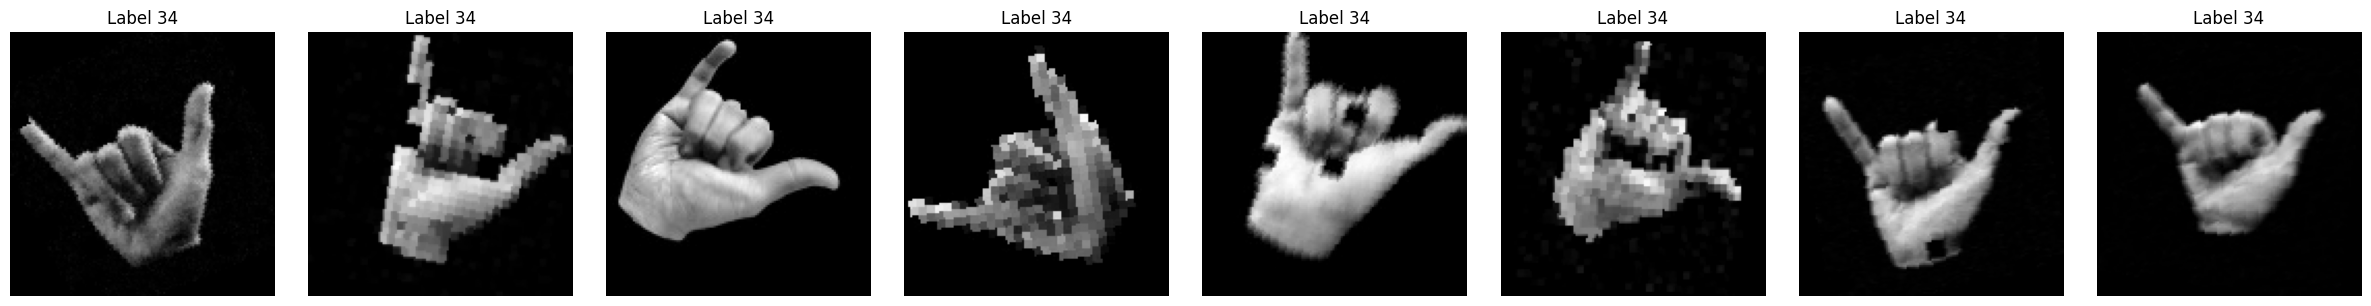

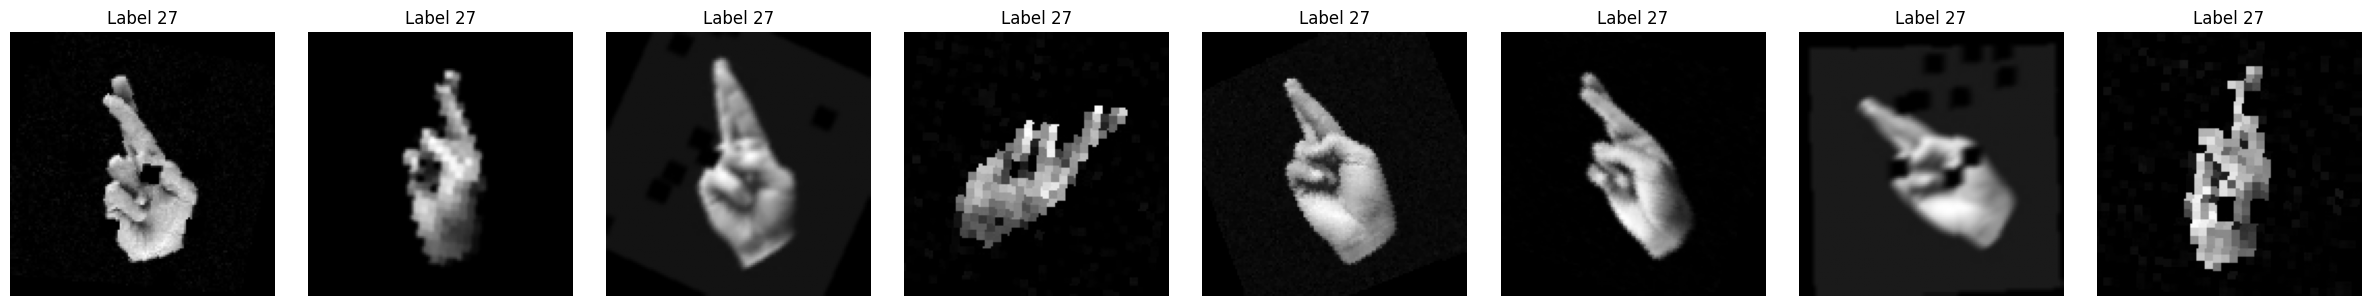

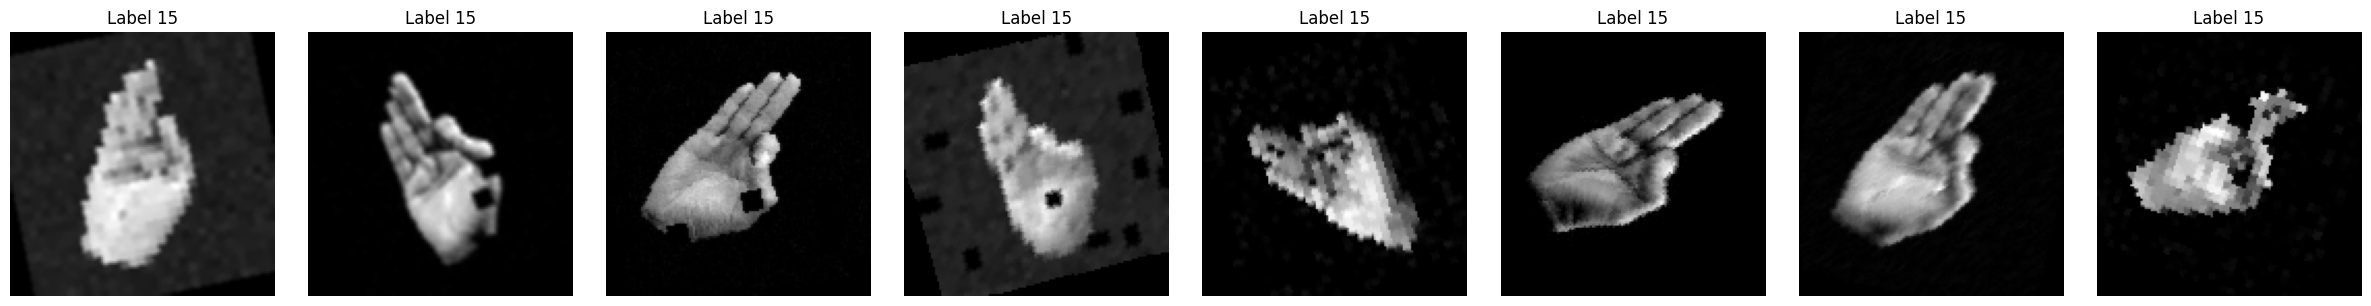

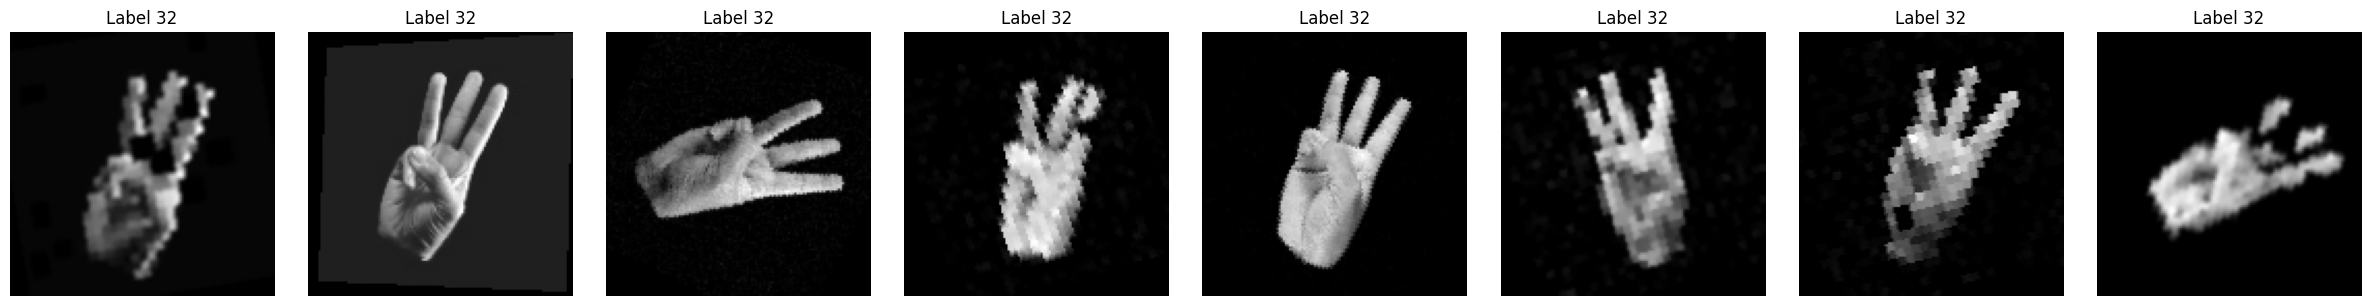

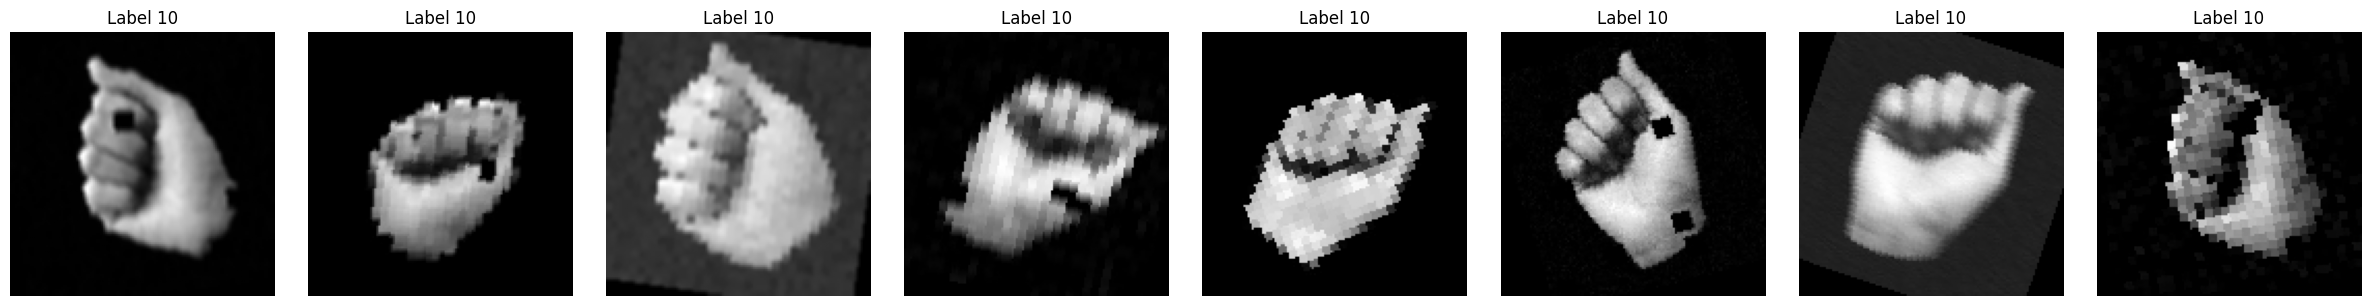

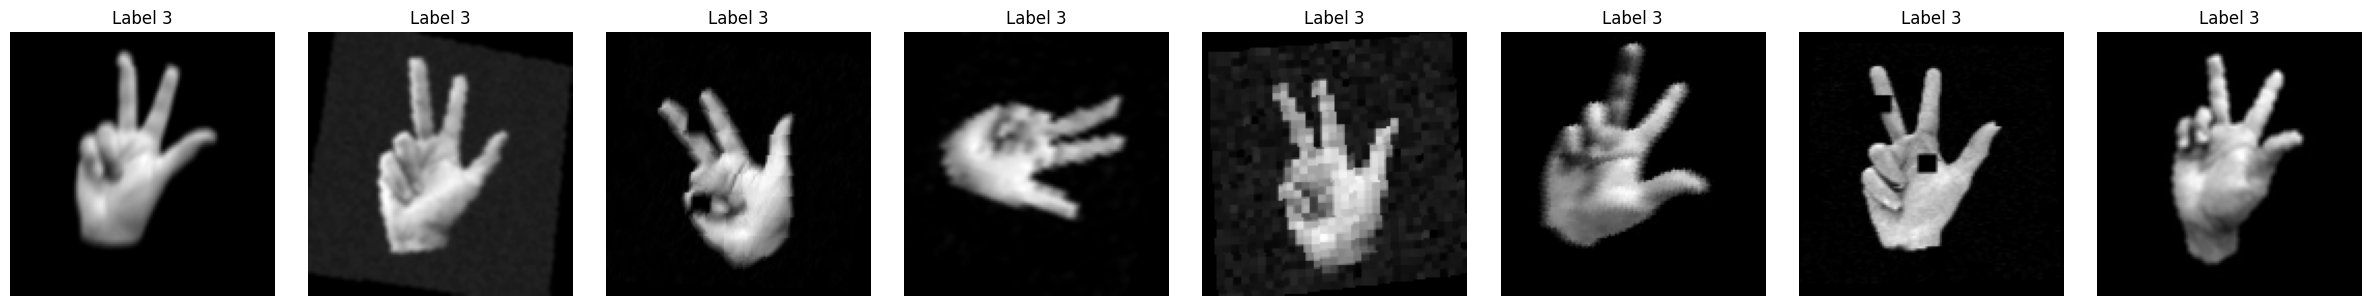

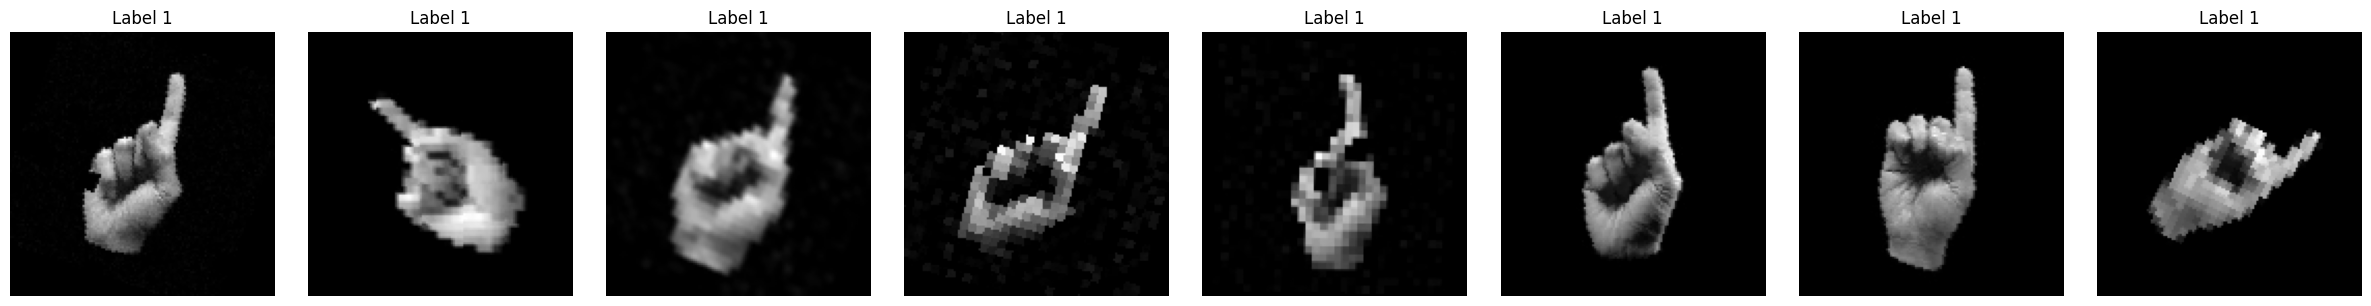

In [11]:
grouped_augmented = defaultdict(list)
for entry in augmented_data:
    grouped_augmented[entry['label']].append(entry['image'])

for label, images in grouped_augmented.items():
    num_imgs = min(len(images), 8)
    fig, axes = plt.subplots(1, num_imgs, figsize=(num_imgs * 3, 3))

    if num_imgs == 1:
        axes = [axes]

    for j in range(num_imgs):
        img = images[j][0]
        axes[j].imshow(img, cmap='gray')
        axes[j].axis('off')
        axes[j].set_title(f"Label {label}")

    plt.tight_layout()
    plt.show()

Now, we can combine the augmented data with the originally given dataset.

In [12]:
augmented_dataset = CombinedDataset(dataset, augmented_data)

Let's also visualize the Augmented Dataset again to see the new distribution among classes.

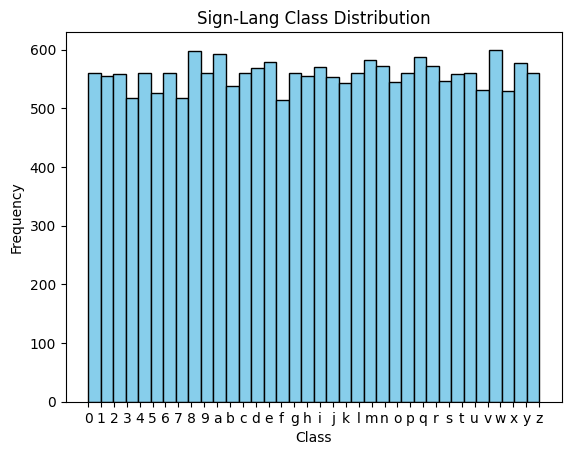

In [13]:
show_class_balancing(augmented_dataset)

### 1.9 Split the Data
Now that we have a good dataset, it is time to split the data into training-, validation- and test-set.

Perform splits 80/10/10

In [14]:
N = len(augmented_dataset)

torch.manual_seed(42)

train_size = int(0.8*N)
test_size = int(0.1*N)
validation_size = N - train_size - test_size

training_dataset, test_dataset, validation_dataset = random_split(augmented_dataset, [train_size, test_size, validation_size])

## 2. Train the model

### 2.1 Use dataloader to create batches for split dataset

First, we will load our dataset by using a dataloader and test if everything works well by printing a random batch.

In [15]:
train_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

### 2.2 Hyperparameters

In [16]:
EPOCHS = 100
PATIENCE = 5
TOLERANCE = 0.15

#### Helpers for Pretty Output

In [17]:
column_width = 70
total_width = 100

In [18]:
def print_progress_bar(iteration, total, epo, length=40):
    current = iteration + epo * total
    total_all = total * EPOCHS

    percent = 100 * (current / total_all)
    filled_length = int(length * current // total_all)

    bar = '█' * filled_length + '-' * (length - filled_length)
    sys.stdout.write(f'Progress: |{bar}| {percent:.1f}% Complete\r')
    sys.stdout.flush()

    if current == total_all:
        sys.stdout.write('\n')


def print_train_details(epoch, iteration, loss, batch_acc, epoch_acc, total_batches):
    l_text = f"Epoch {epoch},\tBatch {iteration},\tloss: {loss:.4f}"
    r_text = f"Batch Accuracy: {batch_acc:.4f}%,\tEpoch Accuracy: {epoch_acc:.4f}%"
    aligned_text = (l_text.ljust(int(column_width)) + r_text.rjust(int(column_width)))
    print(aligned_text.center(total_width))
    print('[' + ''.center(column_width*2, '-') + ']')
    print_progress_bar(iteration + 1, total_batches, epo=epoch, length=40)

def print_validation_details(val_acc, best_acc, loss):
    l_text = f"loss: {loss:.4f},\tPatience-Level: {patience_counter}"
    r_text = f"Best Accuracy so far: {best_acc:.4f}%,\t Validation Accuracy: {val_acc:.4f}%"
    aligned_text = (l_text.ljust(int(column_width)) + r_text.rjust(int(column_width)))
    print(aligned_text.center(total_width))

### 2.3 The Train-Loop
We will use Cross Entropy to calculate loss.
$$
\displaystyle -\sum_{k\in K}\ y_k\ log(\hat{y}_k)
$$ where K represents all 36 classes.

And we will use Adam optimizer from pytorch, because it introduces a Momentum for weight updates and a dynamic learning rate that slows down on plateaus.

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

In the Training loop, we use a few variables to help us track the training process like loss per batch, loss per epoch, accuracy, etc.

Furthermore, we have defined a very high number of Epochs. The reason for this is that we perform early-stopping which will essentially stop the training at the right time and prevent overfitting.

We perform early-stopping by running through the validation-set after each training epoch and check our accuracy on the validation-set. If the validation does not score a any improvements for five times in a row, we break the training loop. The variable to track this behavior is called patience counter.

In [20]:
best_val = float('-inf')
patience_counter = 0
val_history = []
val_loss_history = []

for epoch in range(EPOCHS):
    text = "=====Training - Tracker====="
    print(text.center(column_width*2))
    cnn.train()

    epoch_total = 0
    trn_corr = 0
    batch_size = 0
    total_batches = len(train_loader)


    for i, batch in enumerate(train_loader):
        images = batch['image'].float()
        labels = batch['label']
        batch_size = images.size(0)

        y_pred = cnn(images)
        loss = criterion(y_pred, labels)

        predicted = torch.max(y_pred, 1)[1]
        batch_corr = (predicted == labels).sum()
        trn_corr += batch_corr
        epoch_total += batch_size

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 50 == 0:
            batch_acc = batch_corr / batch_size * 100
            epoch_acc = trn_corr / epoch_total * 100
            print_train_details(epoch, i, loss, batch_acc, epoch_acc, total_batches)

    text = "=====Validation - Analysis====="
    print(text.center(column_width*2))

    cnn.eval()
    val_corr = 0
    total_loss = 0
    total_batches = len(validation_loader)
    num_samples = 0
    with torch.no_grad():

        for i, batch in enumerate(validation_loader):
            images = batch['image'].float()
            labels = batch['label']
            batch_size = images.size(0)

            y_pred = cnn(images)
            loss = criterion(y_pred, labels)
            total_loss += loss.item()

            predicted = torch.max(y_pred, 1)[1]
            batch_corr = (predicted == labels).sum().item()
            val_corr += batch_corr
            num_samples += batch_size

        val_acc = val_corr / num_samples * 100
        total_loss = total_loss / total_batches

        if val_acc > (best_val - TOLERANCE):
            patience_counter = 0
            best_val = val_acc
            torch.save(cnn.state_dict(), '../models/cnn_checkpoint_weights_only.pt')
        else:
            patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Patience exceeded! Breaking training...")
            print_validation_details(val_acc, best_val, total_loss)
            break
        val_history.append(val_acc)
        val_loss_history.append(total_loss)
    print_validation_details(val_acc, best_val, total_loss)
cnn.load_state_dict(torch.load('../models/cnn_checkpoint_weights_only.pt'))

                                                        =====Training - Tracker=====                                                        
Epoch 0,	Batch 0,	loss: 8.6256                                                              Batch Accuracy: 0.0000%,	Epoch Accuracy: 0.0000%
[--------------------------------------------------------------------------------------------------------------------------------------------]
Epoch 0,	Batch 50,	loss: 3.2332                                                            Batch Accuracy: 15.6250%,	Epoch Accuracy: 4.9020%
[--------------------------------------------------------------------------------------------------------------------------------------------]
Epoch 0,	Batch 100,	loss: 3.3102                                                           Batch Accuracy: 12.5000%,	Epoch Accuracy: 7.3020%
[--------------------------------------------------------------------------------------------------------------------------------------------]
Epoch 0

<All keys matched successfully>

Now lets also visualize the progression of the validation-accuracy

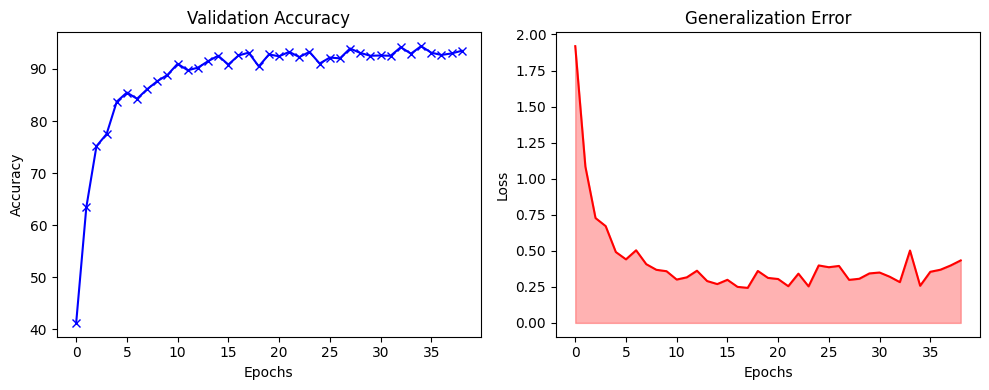

In [21]:
epochs = range(len(val_history))
val_accuracy = val_history

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(epochs, val_accuracy, marker='x', color='blue')
axs[0].set_title('Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')

axs[1].plot(epochs, val_loss_history, color='red')
axs[1].fill_between(epochs, val_loss_history, color='red', alpha=0.3)
axs[1].set_title('Generalization Error')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

And lastly, we will test our model on a test-set and monetize results like accuracy and loss.

In [22]:
cnn.eval()
correct = 0
num_samples = 0
avg_loss = 0
for i, batch in enumerate(test_loader):
    images = batch['image']
    labels = batch['label']

    y_pred = cnn(images)
    loss = criterion(y_pred, labels)

    predicted = torch.max(y_pred, 1)[1]
    batch_corr = (predicted == labels).sum()
    correct += batch_corr

    num_samples += images.size(0)
    avg_loss += loss

avg_loss = avg_loss / len(test_loader)
text = "=====Test - Results====="
print(text.center(column_width*2))
print(f"Correct predctions: {correct}/{num_samples}, Accuracy: {correct / num_samples * 100:.4f}, Average Loss: {avg_loss:.4f}")

                                                          =====Test - Results=====                                                          
Correct predctions: 1882/2009, Accuracy: 93.6784, Average Loss: 0.2490


Save the model weights. Only do that if you are sure you want to save the weights.

In [25]:
torch.save(cnn.state_dict(), "../models/cnn_weights.pt")
torch.save(cnn, '../models/cnn_model.pt')